In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import numpy.fft as fft2
from scipy.signal import butter,lfilter,iirfilter,welch,iirnotch
import matplotlib.mlab as mlab
import mne
import os

This is what the raw data looks like

In [2]:
namesTxt = [i for i in os.listdir() if i[-4:]==".txt"]
namesTxt
for name in namesTxt:
    df = pd.read_csv(name,skiprows=6,header=None)
    fig = plt.subplots(4,2,figsize=(8,10))
    for i in range(4*2):
        plt.subplot(4,2,i+1)
        plt.title("EEG data raw {} (mV)\n{}".format(i,name[:10]))
        plt.plot(df[i+1][10:])
    plt.tight_layout()
    plt.show()

It looks kinda bad doesn't it... The signals are hairy and they drift. 

In [3]:
df=pd.read_csv("./2019_data/1_rest_left_right_10s_OpenBCI-RAW-2019-03-15_18-09-34.txt",skiprows=6,header=None)
arr = np.asarray(df[1][:])
raw_eeg = []
for i in range(1,9):
    raw_eeg.append(np.asarray(df[i][:]))
raw_eeg = np.asarray(raw_eeg)
subarr = arr[2000:2500]

Now lets epoch (or window) the data

119000


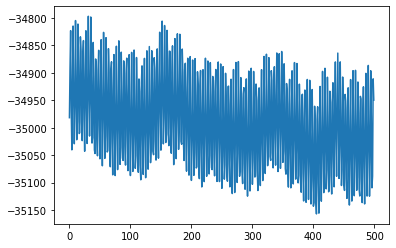

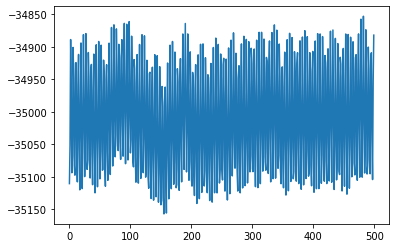

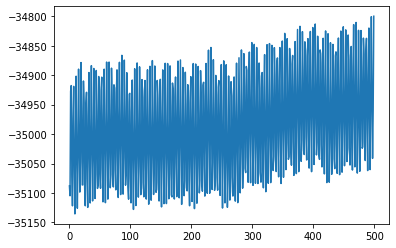

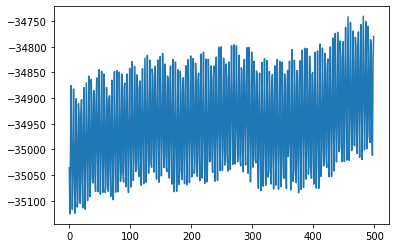

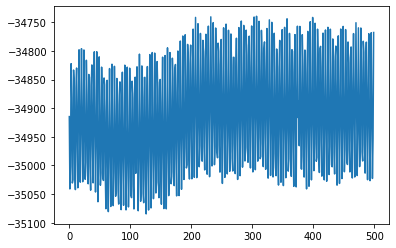

In [4]:
def epoch_data(data, window_length = 2,overlap=0.5):
        """
        Separates the data into equal sized windows

        Input:
            - data: data to seperate into windows
            - window_length: length of the window in seconds
            - overlap: overlap, float in [0,1), in percentage overlap of windows
            
        Output:
            an array of windows, each 

        """
        sample_rate = 250
        array_epochs = []
        i = 0
        window_size_hz = int(window_length * sample_rate)
        overlap_size_hz = int(overlap * window_length * sample_rate)

        while(i  <= len(data)-window_size_hz ):
            array_epochs.append(data[i:i+ window_size_hz ])
            i = i + window_size_hz - overlap_size_hz # This is what the raw data looks like
        
#         if i is not len(data) - 1:
#         array_epochs.append(data[i:len(data)])
        
        return np.array(array_epochs) 

# takes an array of epochs (epoched data) -- the kind returned by
def plot_epoched(epoched,maxdisp=50):
    for n,i in enumerate(epoched):
        if n>=maxdisp:
            break
        plt.figure()
        plt.plot(i)
        plt.show()
        
epoched = epoch_data(arr,overlap=0.5)
print(epoched.size)
plot_epoched(epoched,5)

test the mne built-in notch and bandpass filters

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Setting up band-pass filter from 5 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 413 samples (1.652 sec)



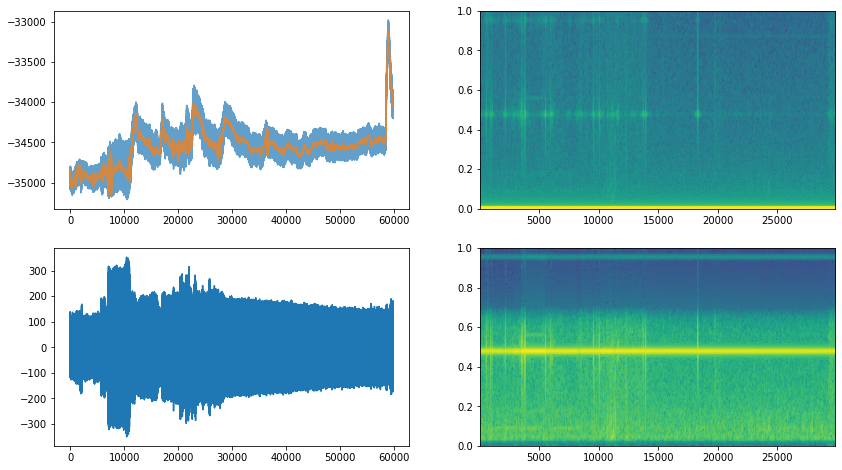

In [5]:
arr.shape
plt.subplots(2,2,figsize=(14,8))
plt.subplot(221)
plt.plot(arr,alpha=0.7)
filt_arr = mne.filter.notch_filter(arr,250,[60,120])
plt.plot(filt_arr,alpha=0.7)
plt.subplot(222)
plt.specgram(filt_arr)

plt.subplot(223)
bp_filtered_arr=mne.filter.filter_data(arr,250,l_freq=5,h_freq=70)
# plt.plot(arr)
plt.plot(bp_filtered_arr)
plt.subplot(224)
plt.specgram(bp_filtered_arr)

plt.show()

In [6]:
# filter eeg data using numpy 
def filter_eeg(eeg_data,apply_notch=True,apply_bp=True):
    sample_rate = 250
    bp_lowcut =5
    bp_highcut =70
    bp_order=2
    notch_freq_Hz  = [60.0, 120.0]
    notch_order =2
    nyq = 0.5 * sample_rate #Nyquist frequency - to prevent aliasing (distortion from freq being too high)
    low = bp_lowcut / nyq
    high = bp_highcut / nyq


    # Butter, get parameters of bandpass filters
    b_bandpass, a_bandpass = butter(bp_order, [low , high],
                                    btype='band', analog=True)
    filtered_eeg = raw_eeg
    if apply_bp:
        filtered_eeg = np.apply_along_axis(lambda l: lfilter(b_bandpass,a_bandpass,l),1,filtered_eeg)
    if apply_notch:
        b_notch,a_notch = iirnotch(60.0,30.0,250)
        filtered_eeg = np.apply_along_axis(lambda l: lfilter(b_notch,a_notch,l),1,filtered_eeg)
        b_notch,a_notch = iirnotch(120.0,30.0,250)
        filtered_eeg = np.apply_along_axis(lambda l: lfilter(b_notch,a_notch,l),1,filtered_eeg)

    return filtered_eeg

# a whole bunch of signals in an n_chann x big_number array
def filter_eeg_mne(eeg_data,apply_notch=True,apply_bp=True):
    sample_rate=250
    bp_lowcut=5
    bp_highcut=70
    bp_order=2
    notch_freq_Hz = [60.0,120.0]
    notch_order = 2
    
    filtered_eeg = eeg_data
    # notch filter
    if apply_notch:
        filtered_eeg = np.apply_along_axis(lambda l:mne.filter.notch_filter(l,250,notch_freq_Hz),1,filtered_eeg)
    if apply_bp:
        filtered_eeg = np.apply_along_axis(lambda l:mne.filter.filter_data(l,250,l_freq=5,h_freq=70),1,filtered_eeg)
    return filtered_eeg

# only a single signal
def filter_eeg_mne_signal(eeg_data,apply_notch=True,apply_bp=True):
    sample_rate=250
    bp_lowcut=5
    bp_highcut=70
    bp_order=2
    notch_freq_Hz = [60.0,120.0]
    notch_order = 2
    
    filtered_eeg = eeg_data
    # notch filter
    if apply_notch:
        filtered_eeg = mne.filter.notch_filter(filtered_eeg,250,notch_freq_Hz)
    if apply_bp:
        filtered_eeg = mne.filter.filter_data(filtered_eeg,250,l_freq=5,h_freq=70)
    return filtered_eeg

In [7]:
filt_eeg = filter_eeg(raw_eeg)
filt_mne = filter_eeg_mne(raw_eeg)
bp_eeg = filter_eeg(raw_eeg,apply_notch=False)
notch_eeg = filter_eeg(raw_eeg,apply_bp=False)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband att

In [8]:
def display_bunch(data,name="title",cut=0):
    for n,i in enumerate(data):
        plt.subplots(1,3,figsize=(15,3))
        plt.subplot(1,3,1)
        plt.title("{} {}".format(name,n))
        plt.plot(i[2000:2200])
        plt.subplot(1,3,2)
        plt.plot(i[cut:])
        plt.subplot(1,3,3)
        plt.specgram(i)
        plt.title("spectrogram")
        plt.tight_layout()
        plt.show()

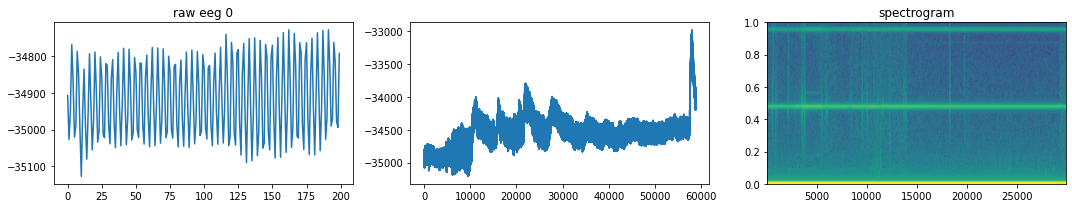

/home/steve/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


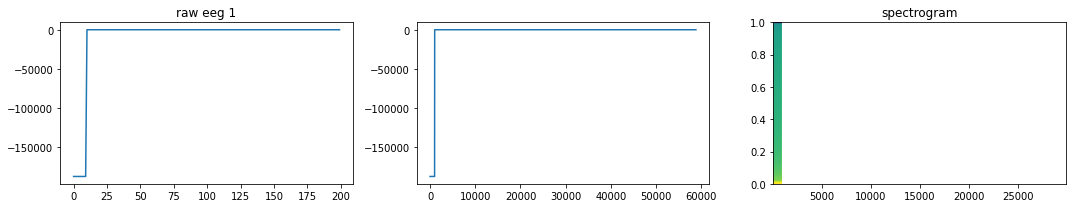

/home/steve/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


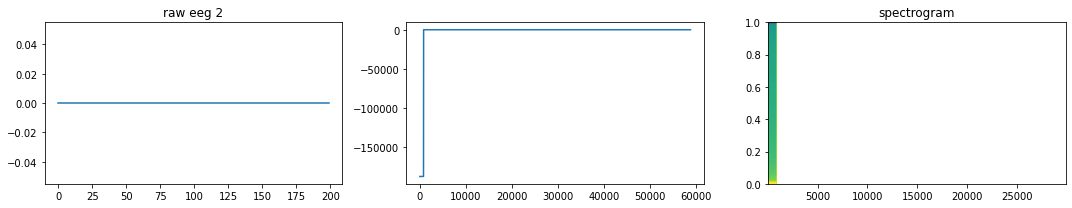

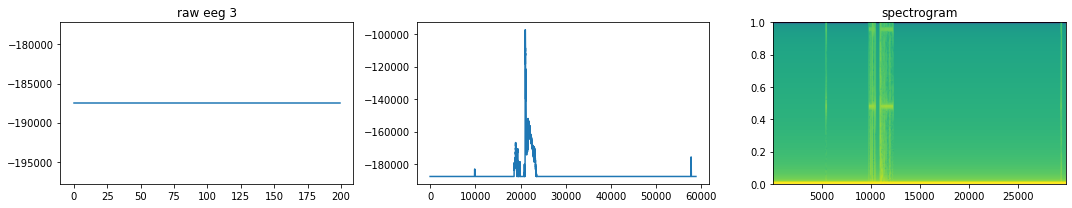

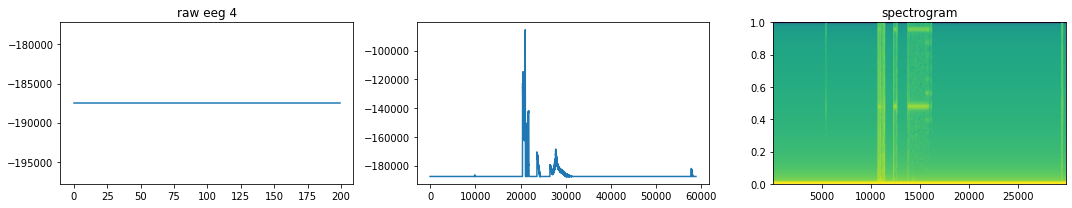

/home/steve/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


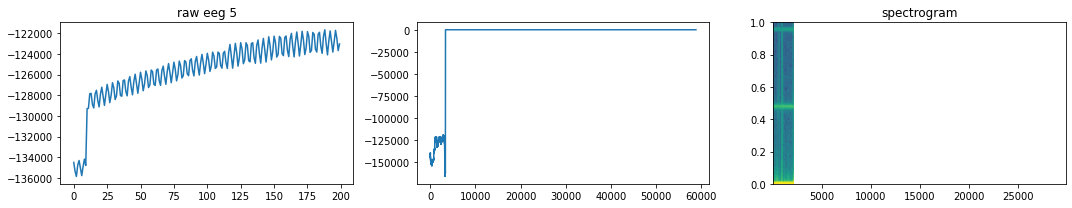

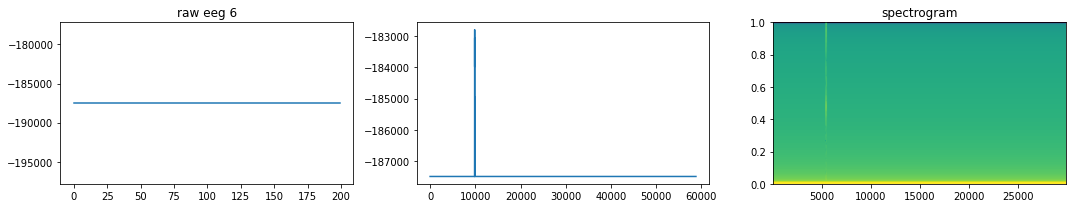

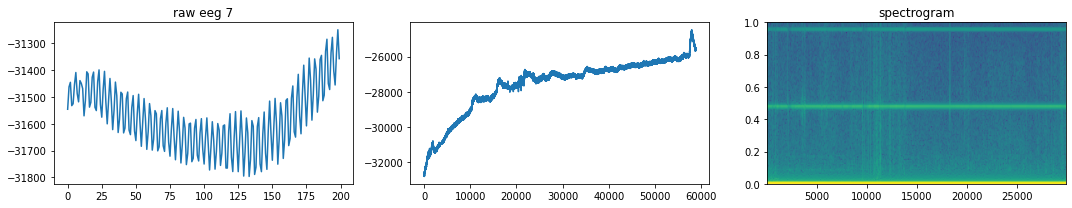

In [9]:
# raw 
display_bunch(raw_eeg,name="raw eeg",cut=1000)

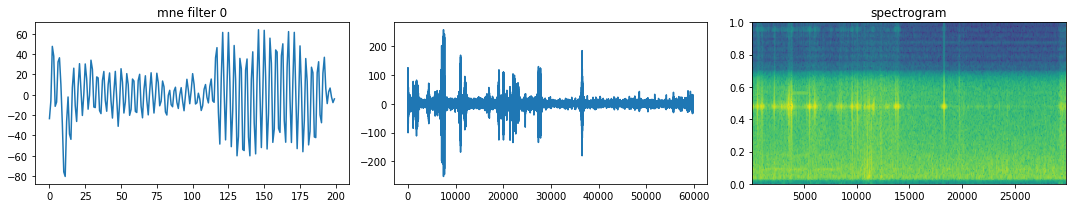

/home/steve/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


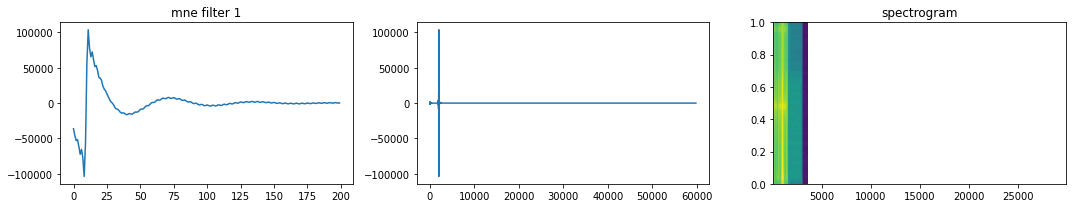

/home/steve/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


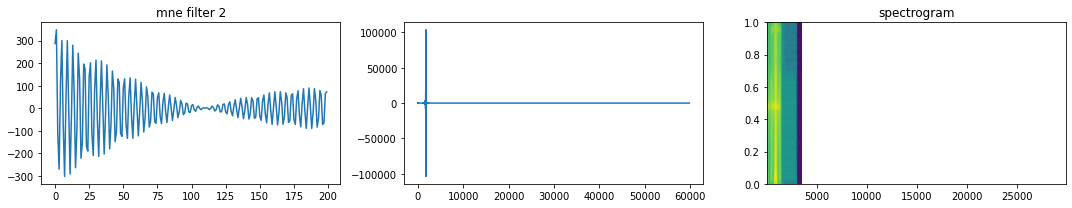

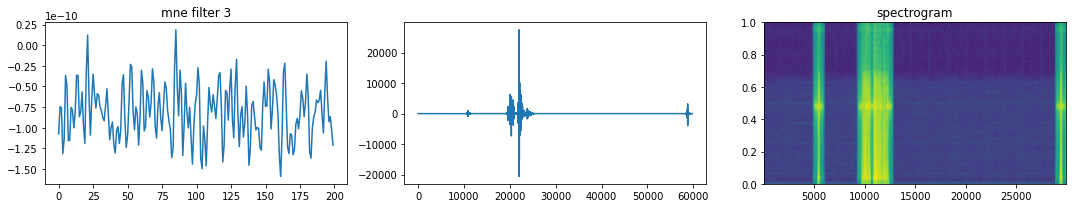

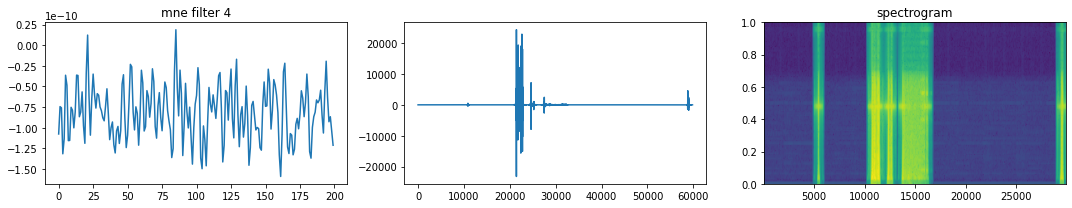

/home/steve/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


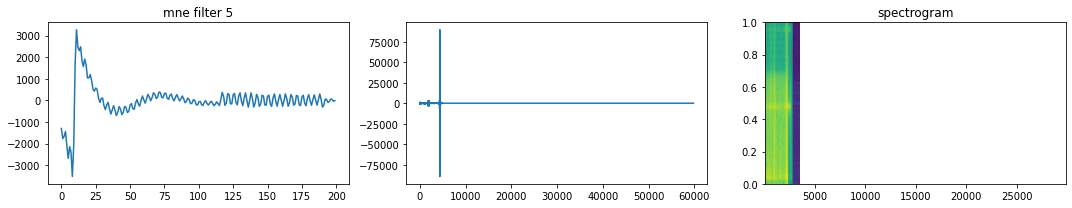

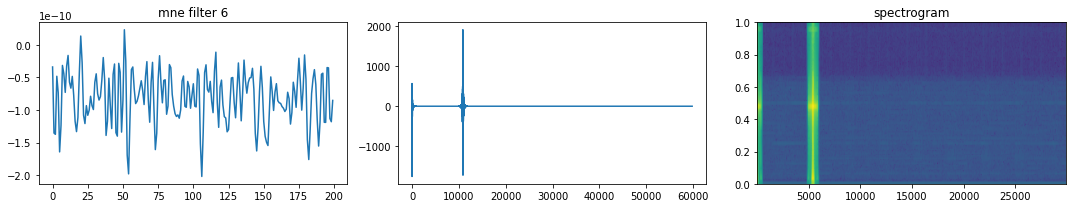

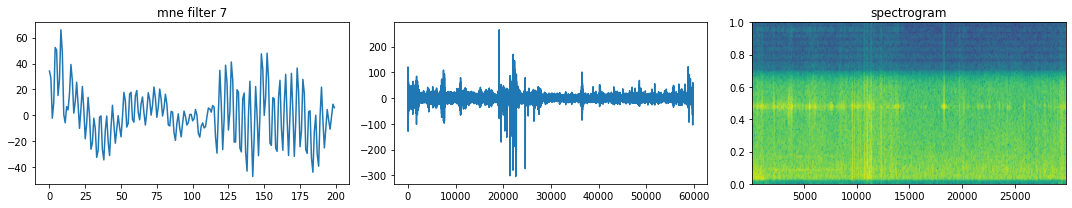

In [10]:
# display mne filtered
display_bunch(filt_mne,name="mne filter",cut=0)

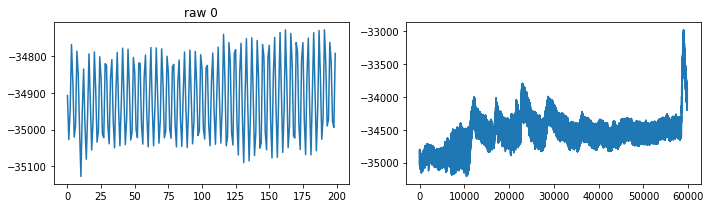

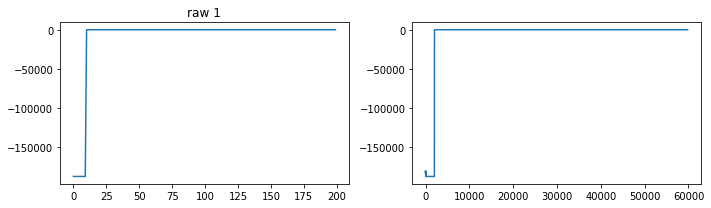

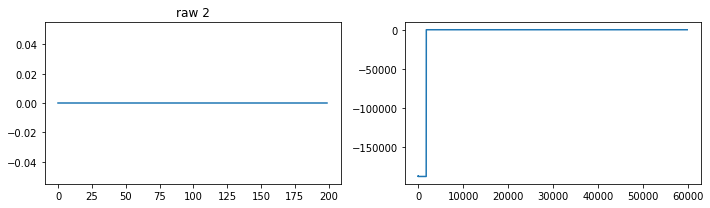

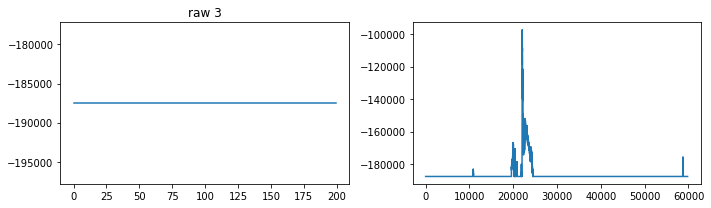

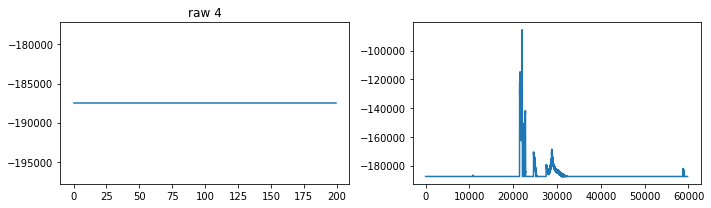

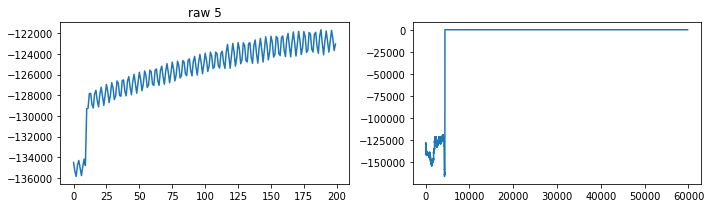

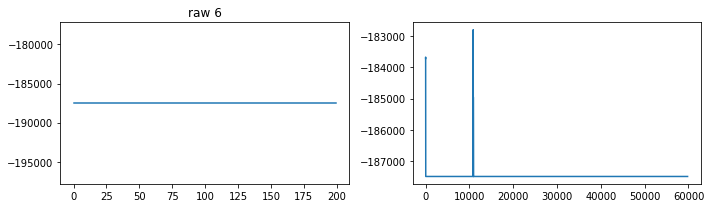

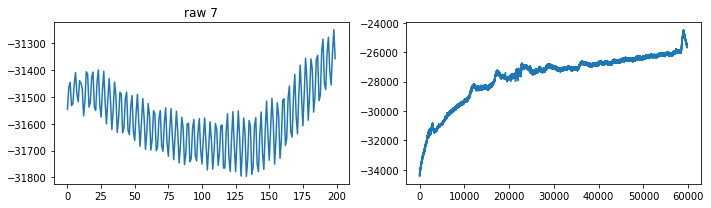

In [11]:
# display raw
for n,i in enumerate(raw_eeg):
    plt.subplots(1,2,figsize=(10,3))
    plt.subplot(1,2,1)
    plt.title("raw {}".format(n))
    plt.plot(i[2000:2200])
    plt.subplot(1,2,2)
    plt.plot(i)
    plt.tight_layout()
    plt.show()

## other data

In [12]:
df = np.loadtxt("./2019_data/March_11/1_JawRest_JawRightClench_10s.txt",
               delimiter=",",skiprows=7,usecols=[1,2,3,4,5,6,7,8])

In [13]:
df = pd.read_csv("./2019_data/March_11/1_JawRest_JawRightClench_10s.txt",
                skiprows=7)


In [14]:
df.head()

,1,48768.33,41347.91,18657.67,23346.91,27563.61,46498.85,68553.71,33379.34,0.000,0.000.1,0.000.2,16:19:28.643,1552335568643
0,2,48761.09,41341.14,18648.89,23342.69,27553.46,46487.92,68543.55,33369.57,0.0,0.0,0.0,16:19:29.124,1552335569124
1,3,48750.11,41330.95,18638.20,23333.95,27544.77,46478.57,68533.93,33359.48,0.0,0.0,0.0,16:19:29.124,1552335569124
2,4,48756.06,41333.38,18636.53,23333.01,27548.28,46481.46,68537.89,33362.10,0.0,0.0,0.0,16:19:29.124,1552335569124
3,5,48760.69,41338.90,18639.61,23335.53,27554.04,46486.78,68543.70,33368.34,0.0,0.0,0.0,16:19:29.124,1552335569124
4,6,48750.63,41334.07,18637.35,23331.78,27549.04,46483.00,68539.12,33366.64,0.0,0.0,0.0,16:19:29.124,1552335569124


## playing with mne

MNE uses units of Volts, but our data is in mV so we need to divide by 1000

In [15]:
import mne

In [16]:
# Create an MNE object from numpy array
ch_types = ['eeg' for i in range(8)]
ch_names = ['ch_{}'.format(i+1) for i in range(8)]
info = mne.create_info(ch_names = ch_names,sfreq=250,ch_types=ch_types)
raw = mne.io.RawArray(raw_eeg,info)
notch = mne.io.RawArray(notch_eeg,info)
bp = mne.io.RawArray(bp_eeg,info)
filtered = mne.io.RawArray(filt_mne,info)

Creating RawArray with float64 data, n_channels=8, n_times=59806
    Range : 0 ... 59805 =      0.000 ...   239.220 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=59806
    Range : 0 ... 59805 =      0.000 ...   239.220 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=59806
    Range : 0 ... 59805 =      0.000 ...   239.220 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=59806
    Range : 0 ... 59805 =      0.000 ...   239.220 secs
Ready.


Plot some stuff

Effective window size : 8.192 (s)


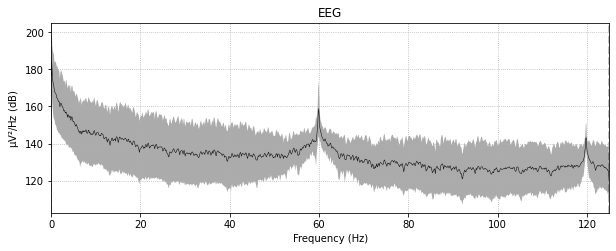

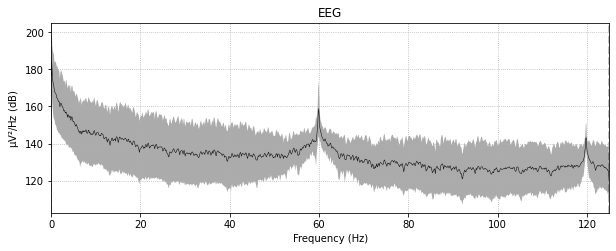

In [17]:
raw.plot_psd(average=True)

Effective window size : 8.192 (s)


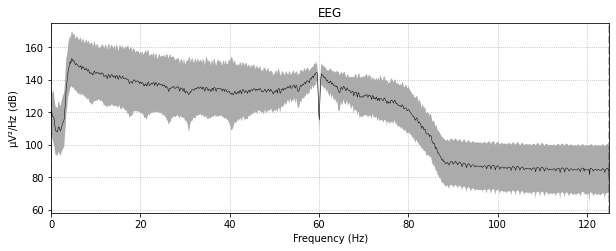

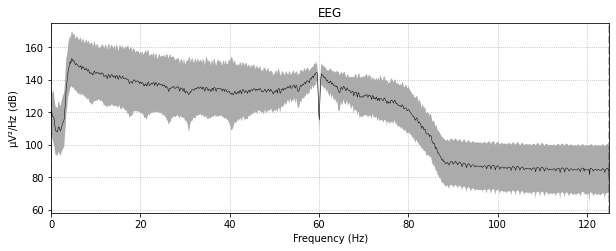

In [18]:
filtered.plot_psd(average=True)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Setting up band-pass filter from 5 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 413 samples (1.652 sec)



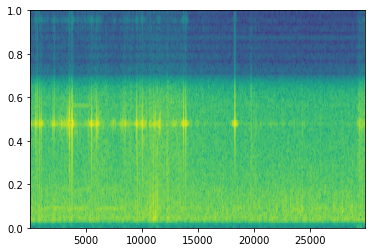

In [19]:
arrf2 = filter_eeg_mne_signal(arr)
type(arrf2)
plt.specgram(arrf2)
plt.show()
# arrf2.shape
# plt.plot(arrf2)

only the notch filter

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)



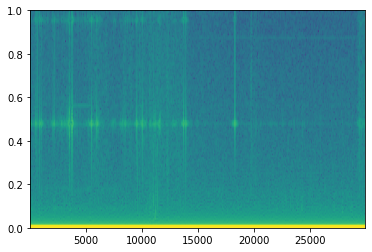

In [20]:
arr_notch = filter_eeg_mne_signal(arr,apply_bp=False)
plt.specgram(arr_notch)
plt.show()

only the bandpass filter

Setting up band-pass filter from 5 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 413 samples (1.652 sec)



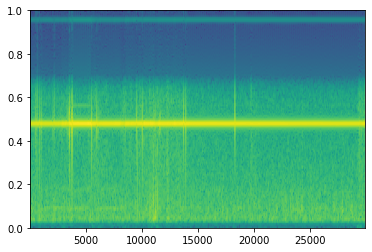

In [21]:
arr_bp = filter_eeg_mne_signal(arr,apply_notch=False)
plt.specgram(arr_bp)
plt.show()